In [1]:
using JuMP, Plots, Ipopt, Statistics, GLM, DataFrames

In [2]:
function water(x,y)  # function wich gives the current velocity according to the x position 
    if is_current_constant 
        wx = 0.8
        wy = 0
    else
        η = @NLexpression(sys,ϵ + sqrt((0.4-ϵ*y)^2 + ϵ^2*x^2))
        wx = @NLexpression(sys,(0.4 - ϵ*y)/ η)
        wy = @NLexpression(sys,ϵ*x / η)
    end
    return wx,wy
end;

In [3]:
# specific parameters for each model 
P = 200 # number of points
N = 5   # number of trailers
M = 5   # number of constrained trailers
is_current_constant = true
ϵ = 1e-2 
μ = 1e-4 # smoothing constant 
time = zeros(N+1)

if N ≥ 2
    l = 1/ N # length of trailers  
else
    l = 1/sqrt(N)
end

# initial data
x0 = 0 
y0 = 0 
c0 = 0
θ0 = π/7

# final data
xf = 4
yf = 7
θf = π/2;

In [4]:
for m in 0 : M
    
    #JuMP model, Ipopt solver
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer,"print_level"=> 5))
    set_optimizer_attribute(sys,"tol",1e-14)
    set_optimizer_attribute(sys,"max_iter",1000)

    JuMP.@variables(sys,begin
        x[1:P]                          # x 
        y[1:P]                          # y 
        θ[1:P]                       # theta 
        -1≤u[1:P]≤1
        0≤ Δt ≤ 1
        c[1:P]
        end) 

    JuMP.@variable(sys, betas[1:P, 1:N])

    #Objective
    @objective(sys,Min,Δt+μ*c[P])


    #Constraints

    @constraints(sys,begin
        x[1] == x0
        y[1] == y0
        θ[1] == θ0
        c[1] == c0

        x[P] == xf
        y[P] == yf
        θ[P] == θf
        end)

    @constraint(sys,c1[j=1:N],
         betas[1,j]==0)


    # constraints for betas(tf)
    if m != 0 
        @constraint(sys,c2[j=1:m],
         betas[P,j]==0) 
    end

    # constraints for betas

    ((@constraint(sys, -sum(asin(l/sqrt(1-(k-1)*l^2)) for k in 1:i)  ≤betas[j,i]≤sum(asin(l/sqrt(1-(k-1)*l^2)) for k in 1:i)  ) for j in 1:P) for i in 1:N)
    
    #Dynamics : Crank-Nicolson

    for j in 1 : P-1
        @NLconstraint(sys, # x' = w + cos(theta)
            x[j+1] == x[j] + 0.5 * Δt * ( water(x[j],y[j])[1] + cos(θ[j]) + water(x[j+1],y[j+1])[1]  + cos(θ[j+1])))
        @NLconstraint(sys, # y' = sin(theta) 
            y[j+1] == y[j] + 0.5* Δt *( water(x[j],y[j])[2] +sin(θ[j])+ sin(θ[j+1])+ water(x[j+1],y[j+1])[2]))
    
        if N ≥ 1  
           @NLconstraint(sys, #beta1 ' = -u- 1/l * sin(beta1)
                betas[j+1,1] == betas[j,1] + 0.5 * Δt * (-u[j]-(1/l)*sin(betas[j,1]) - u[j+1] - (1/l)*sin(betas[j+1,1]))) 
        end
        if N ≥ 2  
            @NLconstraint(sys, #beta2' = -u - cos(beta1)*sin(beta2 - beta1)/l
                betas[j+1,2] == betas[j,2] + 0.5 *  Δt * (-u[j] - cos(betas[j,1])*sin(betas[j,2] - betas[j,1])/l - u[j+1] - cos(betas[j+1,1])*sin(betas[j+1,2] - betas[j+1,1])/l ))   
        end
        if N ≥ 3 
            for i in 3 : N 
              prod1 = @NLexpression(sys,prod(cos(betas[j,p]-betas[j,p-1]) for p in 2 : i-1 )*sin(betas[j,i]-betas[j,i-1])*cos(betas[j,1]) )
              prod2 = @NLexpression(sys,prod(cos(betas[j+1,p]-betas[j+1,p-1]) for p in 2 : i-1 )*sin(betas[j+1,i]-betas[j+1,i-1])*cos(betas[j+1,1]) )  
              @NLconstraint(sys, #betas for i = 3 to N
                    betas[j+1,i] == betas[j,i]+ 0.5*Δt*(-u[j]-prod1/l -u[j+1] -prod2/l ) ) 
            end
        end        
    end
    
    
    @NLconstraint(sys,p_t[j = 1:(P-1)],  # theta ' = u 
            θ[j+1] == θ[j] + 0.5 * Δt * (u[j] + u[j+1]) )

    @NLconstraint(sys, c_[j = 1:(P-1)],  # L2-norm regularization on the control
            c[j+1] == c[j] + 0.5 * Δt * (u[j]^2+ u[j+1]^2))

    #Solve for the control and state
    println("Solving... for M = " , m)
    status = optimize!(sys)
    println("Solver status : ",status)
    println("Cost : " , objective_value(sys))
    time[m+1] = value.(Δt)*P
end;

Solving... for M = 0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    12947
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    53531

Total number of variables............................:     2001
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      201
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1803
Total nu

In [5]:
print(time)

[7.942686069605872, 8.009959034531512, 8.099001261265313, 8.213798784970322, 8.367636055196003, 8.579386180403395]

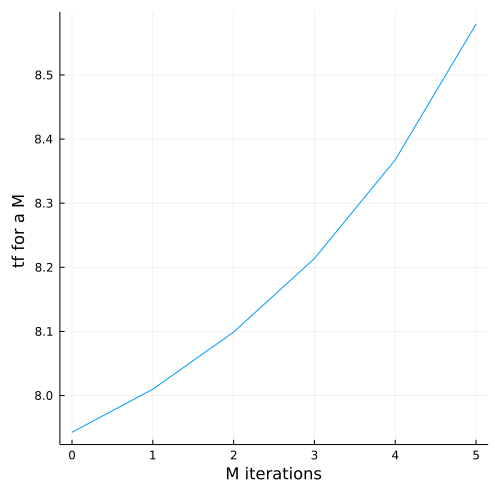

In [6]:
M_ = 0 : N
display(plot(M_, time, size=(500,500), 
    legend = false, xlabel = "M iterations", ylabel = "tf for a M" ))

So we can note a kind (not exactly due to approximations errors) of relation between M and tf, so to find it, we can model that like a suite or like an affine line : 

# Like a suite : 

 * let's approach the common ration : 

In [7]:
coeff = zeros(N)
for i in 1:N 
        coeff[i] = time[i+1] / time[i]
end

In [8]:
mean_coeff = mean(coeff)

1.0155590990293164

* So we can say that for any $M >1 $ ( $\leq N$) :  $$ t_f(M) \simeq t_f(0).mean_{coeff}^M $$  




For instance, the real $t_f$ value for $\theta_f = 3\pi / 2 $, $N = 5$ and $M = 3$ is : 

In [9]:
print(time[4])

8.213798784970322

In [10]:
function suite_model(m)
    value = time[1]*mean_coeff^m
    return value
end

time_suite = zeros(N+1)
for i in 0:N
   time_suite[i+1] = suite_model(i)
end


print("The approximate values are ", time_suite)

The approximate values are [7.942686069605872, 8.066267108721641, 8.19177095746316, 8.319227533015807, 8.448667218049417, 8.580120867960787]

The approximate $t_f$ value for $\theta_f = 3\pi / 2 $, $N = 5$ and $M = 3$ is : 

In [11]:
print(time_suite[4])

8.319227533015807

* let's compare the error percentage : 

In [12]:
error = zeros(N+1)

for i in 0 : N 
    error[i+1] = (abs(time_suite[i+1] - time[i+1]) / time[i+1] )*100
end

print("the percentage error are (in %) : " , error ,"\n" )

mean_error = mean(error[2:end])  # we exclude the first value, because by definition of a suite, the approached value is the same than the real value

print("The mean error is (in %) : ", mean_error)

the percentage error are (in %) : [0.0, 0.7029758073341075, 1.1454461260739834, 1.283556498101699, 0.9683877539474994, 0.008563404676549688]
The mean error is (in %) : 0.8217859180267679

* let's plot our model : 

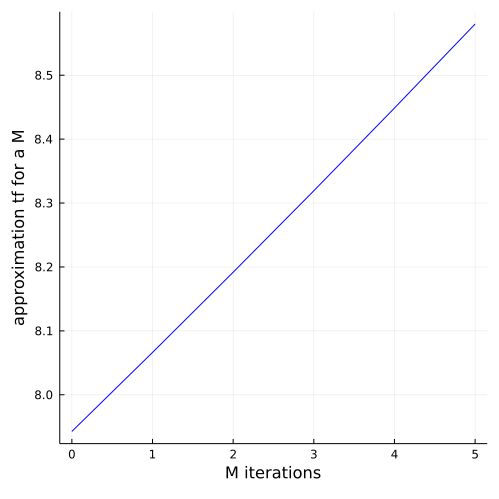

In [13]:
display(plot(M_,time_suite,fmt = :png,size = (500,500),seriestype = :line,legend = false,color = :blue,xlabel = "M iterations",ylabel = " approximation tf for a M " ))

* Let's compare the plot of our both models : 

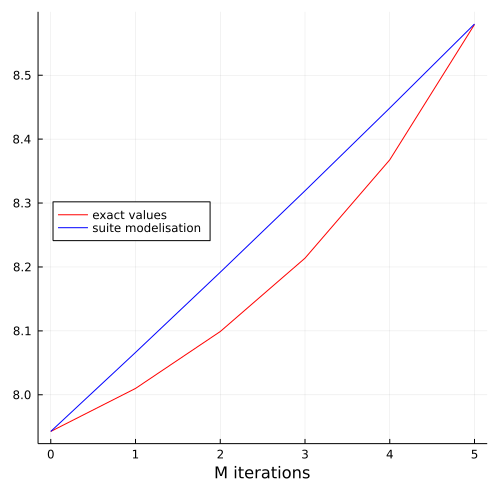

In [14]:
p1 = plot(M_,time,fmt = :png, size = (500,500),label = "exact values",legend = :left, xlabel = "M iterations", color = :red)
p2 = plot!(M_,time_suite,fmt = :png,size = (500,500),label = "suite modelisation",legend = :left,xlabel = "M iterations", color = :blue) 

# Like an affine line : 

- let's make a simple linear regression :

In [15]:
using Lathe

df = DataFrame(M= M_[1:end] , real_time = time[1:end] )
train,test = Lathe.preprocess.TrainTestSplit(df,.75)

(5×2 DataFrame
 Row │ M      real_time 
     │ Int64  Float64   
─────┼──────────────────
   1 │     0    7.94269
   2 │     1    8.00996
   3 │     2    8.099
   4 │     3    8.2138
   5 │     4    8.36764, 1×2 DataFrame
 Row │ M      real_time 
     │ Int64  Float64   
─────┼──────────────────
   1 │     5    8.57939)

In [16]:
fm = @formula(real_time ~ M)
linearRegressor = lm(fm,train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

real_time ~ 1 + M

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  7.91587   0.0239015   331.19    <1e-07  7.8398      7.99193
M            0.105374  0.00975774   10.80    0.0017  0.0743205   0.136427
─────────────────────────────────────────────────────────────────────────

- let's show if we can trust in our model 

We are going to display the $R^2$ coefficient : if it is close to 1, it will mean that our model is very well defined

In [17]:
R = r2(linearRegressor)

0.9749203029284619

* Let's predict the training and test data : 

In [18]:
tf_predicted_test = predict(linearRegressor,test)
tf_predicted_train = predict(linearRegressor,train)

print(tf_predicted_test, "\n" , tf_predicted_train)

Union{Missing, Float64}[8.442738157599523]
Union{Missing, Float64}[7.9158682967899905, 8.021242268951896, 8.126616241113803, 8.23199021327571, 8.337364185437616]

In [19]:
tf_reg = append!(tf_predicted_test,tf_predicted_train)
tf_reg = sort!(tf_reg)

6-element Vector{Union{Missing, Float64}}:
 7.9158682967899905
 8.021242268951896
 8.126616241113803
 8.23199021327571
 8.337364185437616
 8.442738157599523

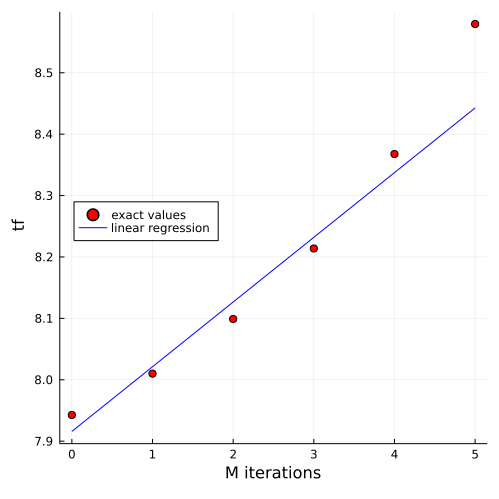

In [20]:
p1 = plot(M_,time,fmt = :png, size = (500,500),seriestype = :scatter,label = "exact values",legend = :left, xlabel = "M iterations",color = :red)
p3 = plot!(M_,tf_reg,fmt = :png,size = (500,500),seriestype = :line,label = "linear regression",xlabel = "M iterations",legend = :left,ylabel = " tf", color = :blue)